In [586]:
import pandas as pd
import numpy as np
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import sklearn as sk
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split


In [587]:

# Directly load into DataFrame
df = pd.read_csv('cumulative_2025.10.04_17.40.12.csv')

print(df.head())

  koi_disposition  koi_period  koi_time0bk  koi_impact  koi_duration  \
0       CONFIRMED    9.488036   170.538750       0.146       2.95750   
1       CONFIRMED   54.418383   162.513840       0.586       4.50700   
2       CANDIDATE   19.899140   175.850252       0.969       1.78220   
3  FALSE POSITIVE    1.736952   170.307565       1.276       2.40641   
4       CONFIRMED    2.525592   171.595550       0.701       1.65450   

   koi_depth  koi_prad  koi_teq  koi_insol  koi_model_snr  koi_steff  \
0      615.8      2.26    793.0      93.59           35.8     5455.0   
1      874.8      2.83    443.0       9.11           25.8     5455.0   
2    10829.0     14.60    638.0      39.30           76.3     5853.0   
3     8079.2     33.46   1395.0     891.96          505.6     5805.0   
4      603.3      2.75   1406.0     926.16           40.9     6031.0   

   koi_slogg  koi_srad         ra        dec  koi_kepmag  
0      4.467     0.927  291.93423  48.141651      15.347  
1      4.467    

In [588]:
print(df.shape)

(9564, 16)


In [589]:
# Map to three categories
df['koi_disposition_class'] = df['koi_disposition'].apply(
    lambda x: 'CONFIRMED' if x == 'CONFIRMED' 
              else ('CANDIDATE' if x == 'CANDIDATE' else 'OTHER')
)

# Encode into numbers
class_map = {'CONFIRMED': 2, 'CANDIDATE': 1, 'OTHER': 0}
df['koi_disposition_encoded'] = df['koi_disposition_class'].map(class_map)

print(df[['koi_disposition', 'koi_disposition_class', 'koi_disposition_encoded']].head())




  koi_disposition koi_disposition_class  koi_disposition_encoded
0       CONFIRMED             CONFIRMED                        2
1       CONFIRMED             CONFIRMED                        2
2       CANDIDATE             CANDIDATE                        1
3  FALSE POSITIVE                 OTHER                        0
4       CONFIRMED             CONFIRMED                        2


In [590]:
df = df.select_dtypes(exclude=['object'])

In [591]:
df = df.fillna(value=np.nan)
print(df.shape)
df = df.dropna()
print(df.shape)

(9564, 16)
(9200, 16)


In [592]:
print(df.shape)
corr_matrix = df.corr().abs()

# Select upper triangle
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Drop columns with correlation > 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
df = df.drop(columns=to_drop)

print(df.shape)


(9200, 16)
(9200, 16)


In [593]:


print(df.shape)

vif = pd.DataFrame()
vif["feature"] = df.columns
vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

high_vif_cols = vif[vif['VIF'] > 10]['feature'].tolist()
high_vif_cols = [col for col in high_vif_cols if col != 'const']
df = df.drop(columns=high_vif_cols)

print(vif)



vif = pd.DataFrame()
vif["feature"] = df.columns
vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
print(vif)
print(df.shape)

(9200, 16)
                    feature         VIF
0                koi_period    1.013608
1               koi_time0bk    8.787871
2                koi_impact    1.951955
3              koi_duration    2.154377
4                 koi_depth    1.722765
5                  koi_prad    1.868674
6                   koi_teq    6.253566
7                 koi_insol    1.585830
8             koi_model_snr    1.753575
9                 koi_steff   70.129539
10                koi_slogg  255.655666
11                 koi_srad    2.508342
12                       ra  526.021830
13                      dec  146.404079
14               koi_kepmag  163.461272
15  koi_disposition_encoded    2.346902
                    feature       VIF
0                koi_period  1.012249
1               koi_time0bk  3.553823
2                koi_impact  1.939862
3              koi_duration  1.867750
4                 koi_depth  1.671078
5                  koi_prad  1.854563
6                   koi_teq  2.294162
7    

In [594]:
# Multinomial logistic regression

X_train, X_test, y_train, y_test = train_test_split(df.drop("koi_disposition_encoded", axis = 1), df["koi_disposition_encoded"] , test_size = 0.2)
from sklearn.preprocessing import PowerTransformer, MinMaxScaler

# 1. Apply Yeo-Johnson to make distribution normal
pt = PowerTransformer(method='yeo-johnson')
X_train_pt = pd.DataFrame(pt.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_pt = pd.DataFrame(pt.transform(X_test), columns=X_test.columns, index=X_test.index)

# 2. Scale to [0,1] after normalization
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_pt), columns=X_train_pt.columns, index=X_train_pt.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_pt), columns=X_test_pt.columns, index=X_test_pt.index)




clf = LogisticRegression(
    max_iter=1000,
    multi_class='multinomial',
    solver='lbfgs',
)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Accuracy:", sk.metrics.accuracy_score(y_test, y_pred))


c:\Users\santi\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy: 0.6597826086956522


c:\Users\santi\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [595]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [596]:
xgb_model = XGBClassifier(
    objective='multi:softmax',
    random_state=42,
    eval_metric='mlogloss'
) 


In [597]:
# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

In [598]:
print("Accuracy:", sk.metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7853260869565217


In [599]:
cm = confusion_matrix(y_test, y_pred)

print(cm)

[[755  90  49]
 [131 218  56]
 [ 24  45 472]]


In [600]:
param_grid = {
    'max_depth': [3, 4, 5, 6, 7, 8],              # tree depth
    'n_estimators': [100, 200, 300, 400, 500],   # number of trees
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2], # step size
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],       # row sampling per tree
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0], # feature sampling per tree
    'gamma': [0, 0.1, 0.2, 0.3],                 # min loss reduction for split
    'reg_alpha': [0, 0.01, 0.1, 1],              # L1 regularization
    'reg_lambda': [1, 1.5, 2],                   # L2 regularization
    'min_child_weight': [1, 3, 5]                # min sum of instance weight in a child
}

In [601]:
rand_search = RandomizedSearchCV(
    xgb_model, param_distributions=param_grid,
    n_iter=100,  # only sample 100 parameter sets
    scoring='balanced_accuracy',  # or 'balanced_accuracy'
    cv=5,
    verbose=2,
    n_jobs=-1
)

rand_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='mlogloss',
                                           feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_con...
                   n_iter=100, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.7, 0.8, 0.9,
                                                             1.0],
                                        'gamma': [0, 0.1, 0.2, 0.3],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.15,
                                                          0.2],
                                        'max_depth': [3, 4, 5, 6, 7, 8],
                                        'min_child_weight': [1, 3, 5],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500],
                                        'reg_alpha': [0, 0.01, 0.1, 1],
                                        'reg_lambda': [1, 1.5, 2],
                                        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0]},
                   scoring='balanced_accuracy', verbose=2)

In [602]:
print("Best parameters found: ", rand_search.best_params_)
print("Best cross-validation accuracy: ", rand_search.best_score_)
best_model = rand_search.best_estimator_
# Predict on test set
y_pred = best_model.predict(X_test)

# Evaluate
print(classification_report(y_test, y_pred, target_names=['OTHER','CANDIDATE','CONFIRMED']))

Best parameters found:  {'subsample': 1.0, 'reg_lambda': 2, 'reg_alpha': 0.1, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.15, 'gamma': 0.2, 'colsample_bytree': 0.8}
Best cross-validation accuracy:  0.742524596024258
              precision    recall  f1-score   support

       OTHER       0.83      0.84      0.83       894
   CANDIDATE       0.61      0.53      0.57       405
   CONFIRMED       0.81      0.87      0.84       541

    accuracy                           0.78      1840
   macro avg       0.75      0.75      0.75      1840
weighted avg       0.78      0.78      0.78      1840



           OTHER  CANDIDATE  CONFIRMED
OTHER        751         92         51
CANDIDATE    133        215         57
CONFIRMED     22         46        473


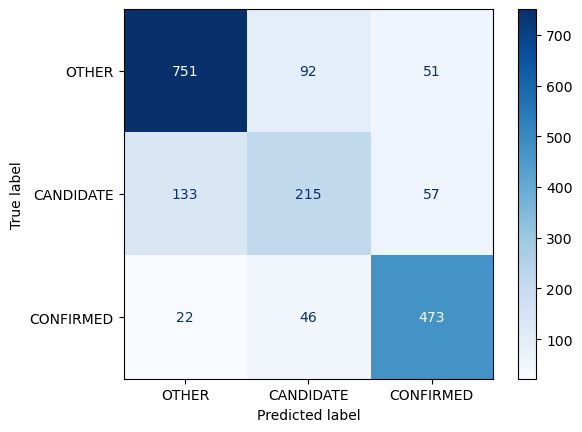

In [603]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=['OTHER','CANDIDATE','CONFIRMED'], columns=['OTHER','CANDIDATE','CONFIRMED'])
print(cm_df)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['OTHER','CANDIDATE','CONFIRMED'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [604]:
feature_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_model.feature_importances_
}).sort_values(by='importance', ascending=False)

print(feature_importances)

         feature  importance
8  koi_model_snr    0.213290
5       koi_prad    0.206459
0     koi_period    0.135724
6        koi_teq    0.093228
3   koi_duration    0.075087
4      koi_depth    0.072350
7      koi_insol    0.070618
2     koi_impact    0.061202
9       koi_srad    0.038591
1    koi_time0bk    0.033450


<Figure size 1000x800 with 0 Axes>

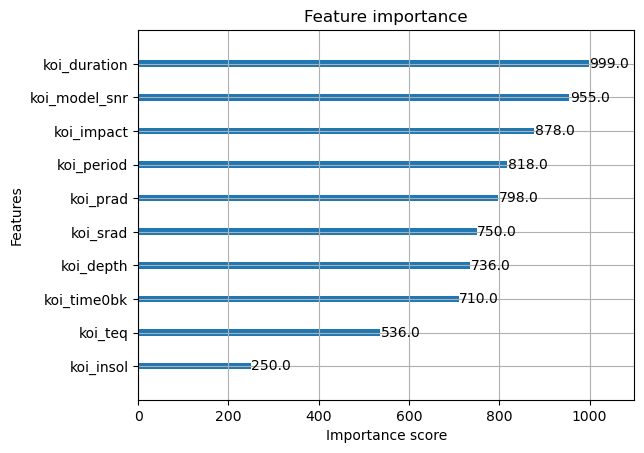

In [605]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

plt.figure(figsize=(10,8))
plot_importance(best_model, max_num_features=20, importance_type='weight')  # or 'gain', 'cover'
plt.show()


In [606]:
top_features = feature_importances.head(4)['feature'].tolist()
print("Top 4 features:", top_features)

Top 4 features: ['koi_model_snr', 'koi_prad', 'koi_period', 'koi_teq']


In [607]:
X_train = X_train[top_features]
X_test = X_test[top_features]


In [608]:
rand_search.fit(X_train, y_train)
print("Best parameters found: ", rand_search.best_params_)
print("Best cross-validation accuracy: ", rand_search.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found:  {'subsample': 0.6, 'reg_lambda': 1, 'reg_alpha': 0.1, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.8}
Best cross-validation accuracy:  0.716278139897673


In [609]:
# Evaluate
print(classification_report(y_test, y_pred, target_names=['OTHER','CANDIDATE','CONFIRMED']))

              precision    recall  f1-score   support

       OTHER       0.83      0.84      0.83       894
   CANDIDATE       0.61      0.53      0.57       405
   CONFIRMED       0.81      0.87      0.84       541

    accuracy                           0.78      1840
   macro avg       0.75      0.75      0.75      1840
weighted avg       0.78      0.78      0.78      1840



           OTHER  CANDIDATE  CONFIRMED
OTHER        751         92         51
CANDIDATE    133        215         57
CONFIRMED     22         46        473


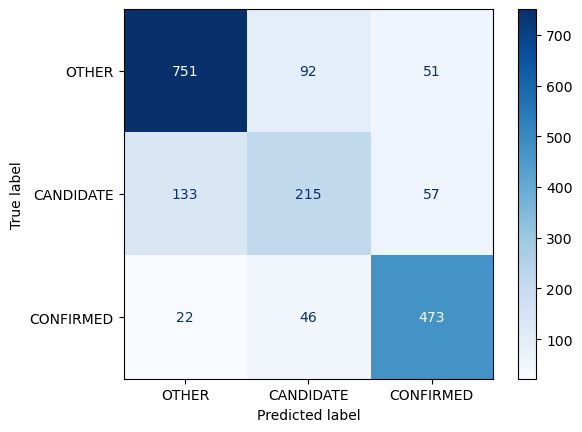

In [610]:
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=['OTHER','CANDIDATE','CONFIRMED'], columns=['OTHER','CANDIDATE','CONFIRMED'])
print(cm_df)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['OTHER','CANDIDATE','CONFIRMED'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [611]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import entropy
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks, regularizers
from tensorflow.keras.utils import to_categorical

In [612]:
class FocalLoss(keras.losses.Loss):
    """Focal Loss for handling class imbalance"""
    def __init__(self, gamma=2.0, alpha=None, name='focal_loss'):
        super().__init__(name=name)
        self.gamma = gamma
        self.alpha = alpha
    
    def call(self, y_true, y_pred):
        epsilon = keras.backend.epsilon()
        y_pred = keras.backend.clip(y_pred, epsilon, 1.0 - epsilon)
        cross_entropy = -y_true * keras.backend.log(y_pred)
        loss = keras.backend.pow(1 - y_pred, self.gamma) * cross_entropy
        
        if self.alpha is not None:
            alpha_t = keras.backend.sum(y_true * self.alpha, axis=-1, keepdims=True)
            loss = alpha_t * loss
        
        return keras.backend.mean(keras.backend.sum(loss, axis=-1))


def create_exoplanet_nn(input_dim, n_classes=3):
    """
    Create neural network optimized for Kepler exoplanet data
    """
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.BatchNormalization(),
        
        # First block - learn complex patterns
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.00001)),
        layers.Dropout(0.25),
        layers.BatchNormalization(),
        
        # Second block - refine features
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.00001)),
        layers.Dropout(0.25),
        layers.BatchNormalization(),
        
        # Third block - final representation
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.00001)),
        layers.Dropout(0.15),
        
        # Output layer
        layers.Dense(32, activation='relu'),
        layers.Dense(n_classes, activation='softmax')
    ])
    
    return model

In [613]:
from sklearn.model_selection import train_test_split

# Create validation set from training data
X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(
    X_train, y_train, 
    test_size=0.15,  # 15% of training for validation
    random_state=42,
    stratify=y_train
)

print(f"Training set: {len(X_train_nn)} samples")
print(f"Validation set: {len(X_val_nn)} samples")
print(f"Test set: {len(X_test)} samples")

# Standardize features (important for neural networks!)
scaler = StandardScaler()
X_train_nn_scaled = scaler.fit_transform(X_train_nn)
X_val_nn_scaled = scaler.transform(X_val_nn)
X_test_nn_scaled = scaler.transform(X_test)

# Convert labels to categorical (one-hot encoding)
y_train_nn_cat = to_categorical(y_train_nn, num_classes=3)
y_val_nn_cat = to_categorical(y_val_nn, num_classes=3)


Training set: 6256 samples
Validation set: 1104 samples
Test set: 1840 samples


In [614]:

# Create model
input_dim = X_train_nn_scaled.shape[1]
nn_model = create_exoplanet_nn(input_dim, n_classes=3)

print(f"Model parameters: {nn_model.count_params():,}")

class_weights = {0: 0.6588, 1: 1.6109, 2: 1.1609}

# Compile with Focal Loss
alpha = np.array([class_weights[i] for i in range(3)])
alpha = alpha / np.sum(alpha)
loss = FocalLoss(gamma=1.5, alpha=alpha)

nn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss=loss,
    metrics=['accuracy']
)

# Callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1
)

# Train
print("\nTraining")
nn_history = nn_model.fit(
    X_train_nn_scaled, y_train_nn_cat,
    validation_data=(X_val_nn_scaled, y_val_nn_cat),
    epochs=200,
    batch_size=16,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Model parameters: 46,163

Training
Epoch 1/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4648 - loss: 0.2033 - val_accuracy: 0.4928 - val_loss: 0.1609 - learning_rate: 3.0000e-04
Epoch 2/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5365 - loss: 0.1536 - val_accuracy: 0.5254 - val_loss: 0.1591 - learning_rate: 3.0000e-04
Epoch 3/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5656 - loss: 0.1462 - val_accuracy: 0.5281 - val_loss: 0.1582 - learning_rate: 3.0000e-04
Epoch 4/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5673 - loss: 0.1450 - val_accuracy: 0.5136 - val_loss: 0.1652 - learning_rate: 3.0000e-04
Epoch 5/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5778 - loss: 0.1388 - val_accuracy: 0.5163 - val_loss: 0.1635 - learning_rate: 3.0000e-04
Epoch 6/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5952 - loss: 0.1371 - val_accuracy: 0.5181 - val_loss: 0.1683 - learning_rate: 3.0000e-04
Epoch 7/200
391/391 ━━━

In [615]:
# Predictions
y_pred_nn_proba = nn_model.predict(X_test_nn_scaled, verbose=0)
y_pred_nn = np.argmax(y_pred_nn_proba, axis=1)

# Classification report
class_names = ['OTHER', 'CANDIDATE', 'CONFIRMED']
print("\nNeural Network Performance:")
print(classification_report(y_test, y_pred_nn, target_names=class_names, digits=4))

# Confusion matrix
cm_nn = confusion_matrix(y_test, y_pred_nn)
print("\nConfusion Matrix:")
print(pd.DataFrame(cm_nn, index=class_names, columns=class_names))



Neural Network Performance:
              precision    recall  f1-score   support

       OTHER     0.7534    0.6186    0.6794       894
   CANDIDATE     0.6667    0.0247    0.0476       405
   CONFIRMED     0.4060    0.8189    0.5429       541

    accuracy                         0.5467      1840
   macro avg     0.6087    0.4874    0.4233      1840
weighted avg     0.6322    0.5467    0.5002      1840


Confusion Matrix:
           OTHER  CANDIDATE  CONFIRMED
OTHER        553          4        337
CANDIDATE     84         10        311
CONFIRMED     97          1        443


In [616]:
# The rand_search was re-fit on the reduced feature set in cell 22.
# We need to update best_model to get the new best estimator.
best_model = rand_search.best_estimator_

y_pred_xgb = best_model.predict(X_test)
y_pred_xgb_proba = best_model.predict_proba(X_test)

# Calculate metrics for both
from sklearn.metrics import precision_score, recall_score

def calculate_metrics(y_true, y_pred):
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision (weighted)': precision_score(y_true, y_pred, average='weighted'),
        'Recall (weighted)': recall_score(y_true, y_pred, average='weighted'),
        'F1 (weighted)': f1_score(y_true, y_pred, average='weighted'),
        'F1 OTHER': f1_score(y_true, y_pred, average=None, zero_division=0)[0],
        'F1 CANDIDATE': f1_score(y_true, y_pred, average=None, zero_division=0)[1],
        'F1 CONFIRMED': f1_score(y_true, y_pred, average=None, zero_division=0)[2],
    }

xgb_metrics = calculate_metrics(y_test, y_pred_xgb)
nn_metrics = calculate_metrics(y_test, y_pred_nn)

# Create comparison table
comparison_df = pd.DataFrame({
    'Metric': list(xgb_metrics.keys()),
    'XGBoost': list(xgb_metrics.values()),
    'Neural Network': list(nn_metrics.values()),
})
comparison_df['Difference (NN - XGB)'] = comparison_df['Neural Network'] - comparison_df['XGBoost']
comparison_df['Winner'] = comparison_df['Difference (NN - XGB)'].apply(
    lambda x: 'NN' if x > 0.001 else ('XGB' if x < -0.001 else 'Tie')
)

print("\n" + "="*80)
print("PERFORMANCE COMPARISON")
print("="*80)
print(comparison_df.to_string(index=False))

# Determine overall winner
avg_improvement = comparison_df['Difference (NN - XGB)'].mean()
if avg_improvement > 0.01:
    print(f"\n✓ Neural Network performs better overall (+{avg_improvement:.4f} average improvement)")
elif avg_improvement < -0.01:
    print(f"\n✓ XGBoost performs better overall ({avg_improvement:.4f} average difference)")
else:
    print("\n≈ Both models perform similarly")

# Key insight
candidate_improvement = nn_metrics['F1 CANDIDATE'] - xgb_metrics['F1 CANDIDATE']
print(f"\nKey Insight - CANDIDATE class F1:")
print(f"  XGBoost:       {xgb_metrics['F1 CANDIDATE']:.4f}")
print(f"  Neural Network: {nn_metrics['F1 CANDIDATE']:.4f}")
print(f"  Improvement:   {candidate_improvement:+.4f} ({candidate_improvement/xgb_metrics['F1 CANDIDATE']*100:+.1f}%)")



PERFORMANCE COMPARISON
              Metric  XGBoost  Neural Network  Difference (NN - XGB) Winner
            Accuracy 0.754348        0.546739              -0.207609    XGB
Precision (weighted) 0.746187        0.632184              -0.114003    XGB
   Recall (weighted) 0.754348        0.546739              -0.207609    XGB
       F1 (weighted) 0.747092        0.500184              -0.246908    XGB
            F1 OTHER 0.808791        0.679361              -0.129430    XGB
        F1 CANDIDATE 0.533708        0.047619              -0.486089    XGB
        F1 CONFIRMED 0.804878        0.542892              -0.261986    XGB

✓ XGBoost performs better overall (-0.2362 average difference)

Key Insight - CANDIDATE class F1:
  XGBoost:       0.5337
  Neural Network: 0.0476
  Improvement:   -0.4861 (-91.1%)


In [617]:
# Average the probabilities from both models
ensemble_proba = 0.5 * y_pred_xgb_proba + 0.5 * y_pred_nn_proba
y_pred_ensemble = np.argmax(ensemble_proba, axis=1)

# Evaluate ensemble
ensemble_metrics = calculate_metrics(y_test, y_pred_ensemble)

print("\nEnsemble Performance:")
print(classification_report(y_test, y_pred_ensemble, target_names=class_names, digits=4))

print("\nEnsemble vs Individual Models:")
ensemble_comparison = pd.DataFrame({
    'Metric': ['Accuracy', 'F1 (weighted)', 'F1 CANDIDATE'],
    'XGBoost': [xgb_metrics['Accuracy'], xgb_metrics['F1 (weighted)'], xgb_metrics['F1 CANDIDATE']],
    'Neural Network': [nn_metrics['Accuracy'], nn_metrics['F1 (weighted)'], nn_metrics['F1 CANDIDATE']],
    'Ensemble': [ensemble_metrics['Accuracy'], ensemble_metrics['F1 (weighted)'], ensemble_metrics['F1 CANDIDATE']]
})
print(ensemble_comparison.to_string(index=False))


Ensemble Performance:
              precision    recall  f1-score   support

       OTHER     0.8040    0.8166    0.8102       894
   CANDIDATE     0.6119    0.5062    0.5541       405
   CONFIRMED     0.7705    0.8503    0.8084       541

    accuracy                         0.7582      1840
   macro avg     0.7288    0.7243    0.7242      1840
weighted avg     0.7519    0.7582    0.7533      1840


Ensemble vs Individual Models:
       Metric  XGBoost  Neural Network  Ensemble
     Accuracy 0.754348        0.546739  0.758152
F1 (weighted) 0.747092        0.500184  0.753307
 F1 CANDIDATE 0.533708        0.047619  0.554054


In [618]:
if nn_metrics['F1 CANDIDATE'] > xgb_metrics['F1 CANDIDATE']:
    best_proba = y_pred_nn_proba
    best_model_name = "Neural Network"
else:
    best_proba = y_pred_xgb_proba
    best_model_name = "XGBoost"

print(f"Using {best_model_name} probabilities for two-stage classification")

# Calculate uncertainties
def calculate_uncertainty(proba):
    return np.array([entropy(p) for p in proba])

uncertainties = calculate_uncertainty(best_proba)

# Two-stage classifier
def two_stage_classify(proba, uncertainties, 
                       other_thresh=0.85, 
                       confirmed_thresh=0.75,
                       other_unc_max=0.40,
                       confirmed_unc_max=0.50):
    """Two-stage classification for exoplanet detection"""
    predictions = []
    confidence_levels = []
    stages = []
    
    for prob, unc in zip(proba, uncertainties):
        p_other, p_candidate, p_confirmed = prob
        
        # Stage 1: High confidence decisions
        if p_other >= other_thresh and unc <= other_unc_max:
            pred, conf, stage = 0, 'HIGH', 'STAGE1_OTHER'
        elif p_confirmed >= confirmed_thresh and unc <= confirmed_unc_max:
            pred, conf, stage = 2, 'HIGH', 'STAGE1_CONFIRMED'
        
        # Stage 2: Route to CANDIDATE
        elif unc >= 0.50:
            pred, conf, stage = 1, 'LOW', 'STAGE2_CANDIDATE'
        elif p_confirmed >= 0.55:
            pred, conf, stage = 1, 'MEDIUM', 'STAGE2_CANDIDATE'
        elif p_other >= 0.60:
            pred, conf, stage = 1, 'MEDIUM', 'STAGE2_CANDIDATE'
        else:
            pred, conf, stage = 1, 'LOW', 'STAGE2_CANDIDATE'
        
        predictions.append(pred)
        confidence_levels.append(conf)
        stages.append(stage)
    
    return np.array(predictions), np.array(confidence_levels), np.array(stages)

# Apply two-stage classification
y_pred_two_stage, conf_levels, stages = two_stage_classify(best_proba, uncertainties)

# Evaluate two-stage
print("\nTwo-Stage Classification Performance:")
print(classification_report(y_test, y_pred_two_stage, target_names=class_names, digits=4))

# Analyze stages
print("\nStage Distribution:")
stage_counts = pd.Series(stages).value_counts()
for stage_name, count in stage_counts.items():
    pct = count / len(stages) * 100
    print(f"  {stage_name:20s}: {count:4d} ({pct:5.1f}%)")

# Key metrics for astronomy
confirmed_mask = y_test == 2
confirmed_caught = (y_pred_two_stage[confirmed_mask] == 2).sum()
confirmed_to_candidate = (y_pred_two_stage[confirmed_mask] == 1).sum()
confirmed_lost = (y_pred_two_stage[confirmed_mask] == 0).sum()

print(f"\nReal CONFIRMED planets (n={confirmed_mask.sum()}):")
print(f"  Correctly classified:    {confirmed_caught} ({confirmed_caught/confirmed_mask.sum()*100:.1f}%)")
print(f"  Routed to review:        {confirmed_to_candidate} ({confirmed_to_candidate/confirmed_mask.sum()*100:.1f}%)")
print(f"  Lost (rejected):         {confirmed_lost} ({confirmed_lost/confirmed_mask.sum()*100:.1f}%)")
print(f"  → Total recoverable:     {confirmed_caught + confirmed_to_candidate} ({(confirmed_caught + confirmed_to_candidate)/confirmed_mask.sum()*100:.1f}%)")


Using XGBoost probabilities for two-stage classification

Two-Stage Classification Performance:
              precision    recall  f1-score   support

       OTHER     0.9433    0.5022    0.6555       894
   CANDIDATE     0.3198    0.9111    0.4734       405
   CONFIRMED     0.9095    0.3530    0.5087       541

    accuracy                         0.5484      1840
   macro avg     0.7242    0.5888    0.5458      1840
weighted avg     0.7961    0.5484    0.5722      1840


Stage Distribution:
  STAGE2_CANDIDATE    : 1154 ( 62.7%)
  STAGE1_OTHER        :  476 ( 25.9%)
  STAGE1_CONFIRMED    :  210 ( 11.4%)

Real CONFIRMED planets (n=541):
  Correctly classified:    191 (35.3%)
  Routed to review:        349 (64.5%)
  Lost (rejected):         1 (0.2%)
  → Total recoverable:     540 (99.8%)


Comprehensive visualization saved to 'complete_pipeline_comparison.png'


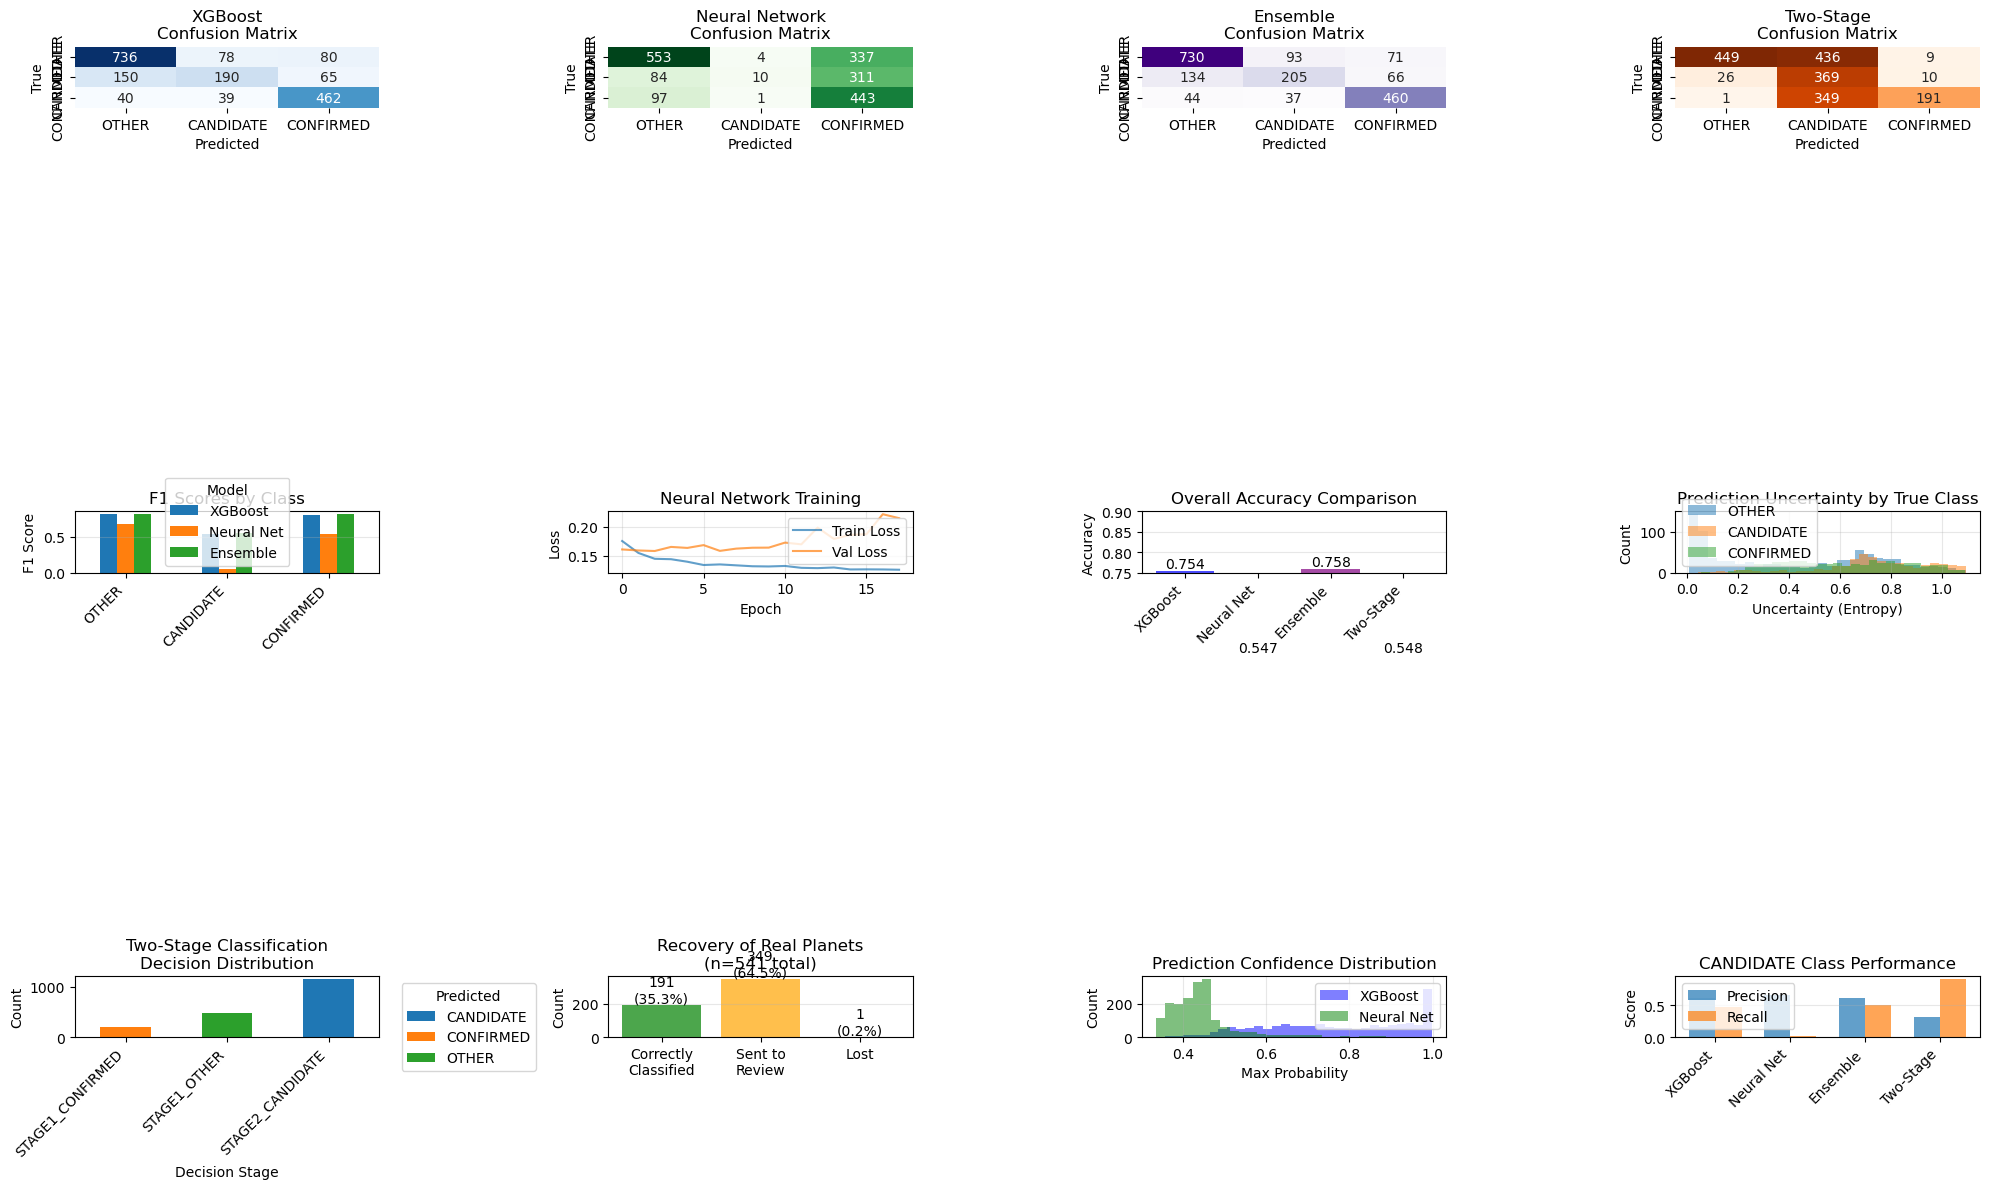

In [619]:
fig = plt.figure(figsize=(20, 12))

# 1. Confusion matrices comparison
ax1 = plt.subplot(3, 4, 1)
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=ax1, cbar=False)
ax1.set_title('XGBoost\nConfusion Matrix')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('True')

ax2 = plt.subplot(3, 4, 2)
sns.heatmap(confusion_matrix(y_test, y_pred_nn), annot=True, fmt='d', cmap='Greens',
            xticklabels=class_names, yticklabels=class_names, ax=ax2, cbar=False)
ax2.set_title('Neural Network\nConfusion Matrix')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('True')

ax3 = plt.subplot(3, 4, 3)
sns.heatmap(confusion_matrix(y_test, y_pred_ensemble), annot=True, fmt='d', cmap='Purples',
            xticklabels=class_names, yticklabels=class_names, ax=ax3, cbar=False)
ax3.set_title('Ensemble\nConfusion Matrix')
ax3.set_xlabel('Predicted')
ax3.set_ylabel('True')

ax4 = plt.subplot(3, 4, 4)
sns.heatmap(confusion_matrix(y_test, y_pred_two_stage), annot=True, fmt='d', cmap='Oranges',
            xticklabels=class_names, yticklabels=class_names, ax=ax4, cbar=False)
ax4.set_title('Two-Stage\nConfusion Matrix')
ax4.set_xlabel('Predicted')
ax4.set_ylabel('True')

# 2. F1 scores comparison
ax5 = plt.subplot(3, 4, 5)
f1_comparison = pd.DataFrame({
    'XGBoost': [xgb_metrics[f'F1 {c}'] for c in class_names],
    'Neural Net': [nn_metrics[f'F1 {c}'] for c in class_names],
    'Ensemble': [f1_score(y_test, y_pred_ensemble, average=None)[i] for i in range(3)],
}, index=class_names)
f1_comparison.plot(kind='bar', ax=ax5)
ax5.set_title('F1 Scores by Class')
ax5.set_ylabel('F1 Score')
ax5.set_xlabel('')
ax5.legend(title='Model')
ax5.grid(True, alpha=0.3, axis='y')
plt.setp(ax5.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 3. Training history (if NN)
ax6 = plt.subplot(3, 4, 6)
ax6.plot(nn_history.history['loss'], label='Train Loss', alpha=0.7)
ax6.plot(nn_history.history['val_loss'], label='Val Loss', alpha=0.7)
ax6.set_xlabel('Epoch')
ax6.set_ylabel('Loss')
ax6.set_title('Neural Network Training')
ax6.legend()
ax6.grid(True, alpha=0.3)

# 4. Accuracy comparison
ax7 = plt.subplot(3, 4, 7)
accuracies = {
    'XGBoost': xgb_metrics['Accuracy'],
    'Neural Net': nn_metrics['Accuracy'],
    'Ensemble': ensemble_metrics['Accuracy'],
    'Two-Stage': accuracy_score(y_test, y_pred_two_stage)
}
bars = ax7.bar(accuracies.keys(), accuracies.values(), 
               color=['blue', 'green', 'purple', 'orange'], alpha=0.7)
ax7.set_ylabel('Accuracy')
ax7.set_title('Overall Accuracy Comparison')
ax7.set_ylim([0.75, 0.90])
ax7.grid(True, alpha=0.3, axis='y')
for bar in bars:
    height = bar.get_height()
    ax7.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}', ha='center', va='bottom')
plt.setp(ax7.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 5. Uncertainty distribution
ax8 = plt.subplot(3, 4, 8)
for i, class_name in enumerate(class_names):
    mask = y_test == i
    ax8.hist(uncertainties[mask], alpha=0.5, bins=30, label=class_name)
ax8.set_xlabel('Uncertainty (Entropy)')
ax8.set_ylabel('Count')
ax8.set_title('Prediction Uncertainty by True Class')
ax8.legend()
ax8.grid(True, alpha=0.3)

# 6. Two-stage analysis
ax9 = plt.subplot(3, 4, 9)
stage_pred_df = pd.DataFrame({
    'stage': stages,
    'predicted': [class_names[i] for i in y_pred_two_stage]
})
stage_counts = stage_pred_df.groupby(['stage', 'predicted']).size().unstack(fill_value=0)
stage_counts.plot(kind='bar', stacked=True, ax=ax9)
ax9.set_xlabel('Decision Stage')
ax9.set_ylabel('Count')
ax9.set_title('Two-Stage Classification\nDecision Distribution')
ax9.legend(title='Predicted', bbox_to_anchor=(1.05, 1))
plt.setp(ax9.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 7. Recovery analysis
ax10 = plt.subplot(3, 4, 10)
recovery_data = {
    'Correctly\nClassified': confirmed_caught,
    'Sent to\nReview': confirmed_to_candidate,
    'Lost': confirmed_lost
}
colors = ['green', 'orange', 'red']
bars = ax10.bar(recovery_data.keys(), recovery_data.values(), color=colors, alpha=0.7)
ax10.set_ylabel('Count')
ax10.set_title(f'Recovery of Real Planets\n(n={confirmed_mask.sum()} total)')
ax10.grid(True, alpha=0.3, axis='y')
for bar in bars:
    height = bar.get_height()
    pct = height / confirmed_mask.sum() * 100
    ax10.text(bar.get_x() + bar.get_width()/2., height,
              f'{int(height)}\n({pct:.1f}%)', ha='center', va='bottom')

# 8. Probability distributions comparison
ax11 = plt.subplot(3, 4, 11)
max_proba_xgb = np.max(y_pred_xgb_proba, axis=1)
max_proba_nn = np.max(y_pred_nn_proba, axis=1)
ax11.hist(max_proba_xgb, alpha=0.5, bins=30, label='XGBoost', color='blue')
ax11.hist(max_proba_nn, alpha=0.5, bins=30, label='Neural Net', color='green')
ax11.set_xlabel('Max Probability')
ax11.set_ylabel('Count')
ax11.set_title('Prediction Confidence Distribution')
ax11.legend()
ax11.grid(True, alpha=0.3)

# 9. CANDIDATE class focus
ax12 = plt.subplot(3, 4, 12)
candidate_metrics = pd.DataFrame({
    'Model': ['XGBoost', 'Neural Net', 'Ensemble', 'Two-Stage'],
    'Precision': [
        precision_score(y_test, y_pred_xgb, average=None)[1],
        precision_score(y_test, y_pred_nn, average=None)[1],
        precision_score(y_test, y_pred_ensemble, average=None)[1],
        precision_score(y_test, y_pred_two_stage, average=None)[1]
    ],
    'Recall': [
        recall_score(y_test, y_pred_xgb, average=None)[1],
        recall_score(y_test, y_pred_nn, average=None)[1],
        recall_score(y_test, y_pred_ensemble, average=None)[1],
        recall_score(y_test, y_pred_two_stage, average=None)[1]
    ]
})
x = np.arange(len(candidate_metrics))
width = 0.35
bars1 = ax12.bar(x - width/2, candidate_metrics['Precision'], width, label='Precision', alpha=0.7)
bars2 = ax12.bar(x + width/2, candidate_metrics['Recall'], width, label='Recall', alpha=0.7)
ax12.set_ylabel('Score')
ax12.set_title('CANDIDATE Class Performance')
ax12.set_xticks(x)
ax12.set_xticklabels(candidate_metrics['Model'])
ax12.legend()
ax12.grid(True, alpha=0.3, axis='y')
plt.setp(ax12.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('complete_pipeline_comparison.png', dpi=300, bbox_inches='tight')
print("Comprehensive visualization saved to 'complete_pipeline_comparison.png'")
plt.show()

In [620]:
print("PIPELINE COMPLETE - SUMMARY")
print("="*80)

print("\n📊 Performance Summary:")
print(f"  XGBoost Accuracy:       {xgb_metrics['Accuracy']:.4f}")
print(f"  Neural Network Accuracy: {nn_metrics['Accuracy']:.4f}")
print(f"  Ensemble Accuracy:      {ensemble_metrics['Accuracy']:.4f}")

print("\n🎯 CANDIDATE Class (The Challenging One):")
print(f"  XGBoost F1:       {xgb_metrics['F1 CANDIDATE']:.4f}")
print(f"  Neural Network F1: {nn_metrics['F1 CANDIDATE']:.4f}")
print(f"  Ensemble F1:      {ensemble_metrics['F1 CANDIDATE']:.4f}")

print("\n🔬 Two-Stage Classification:")
print(f"  Real planets recoverable: {(confirmed_caught + confirmed_to_candidate)/confirmed_mask.sum()*100:.1f}%")
print(f"  Workload for human review: {(stages == 'STAGE2_CANDIDATE').sum()} samples ({(stages == 'STAGE2_CANDIDATE').sum()/len(stages)*100:.1f}%)")

print("\n✅ Recommendation:")
if nn_metrics['F1 CANDIDATE'] > xgb_metrics['F1 CANDIDATE'] + 0.02:
    print("  → Use Neural Network or Ensemble for better CANDIDATE detection")
elif ensemble_metrics['F1 CANDIDATE'] > max(xgb_metrics['F1 CANDIDATE'], nn_metrics['F1 CANDIDATE']):
    print("  → Use Ensemble for best overall performance")
else:
    print("  → XGBoost performs well; Neural Network offers marginal improvement")

print("\n💾 Models saved in memory:")
print("  - best_model (XGBoost)")
print("  - nn_model (Neural Network)")
print("  - scaler (for NN predictions)")
print("  - y_pred_ensemble (ensemble predictions)")
print("  - y_pred_two_stage (two-stage predictions)")

PIPELINE COMPLETE - SUMMARY

📊 Performance Summary:
  XGBoost Accuracy:       0.7543
  Neural Network Accuracy: 0.5467
  Ensemble Accuracy:      0.7582

🎯 CANDIDATE Class (The Challenging One):
  XGBoost F1:       0.5337
  Neural Network F1: 0.0476
  Ensemble F1:      0.5541

🔬 Two-Stage Classification:
  Real planets recoverable: 99.8%
  Workload for human review: 1154 samples (62.7%)

✅ Recommendation:
  → Use Ensemble for best overall performance

💾 Models saved in memory:
  - best_model (XGBoost)
  - nn_model (Neural Network)
  - scaler (for NN predictions)
  - y_pred_ensemble (ensemble predictions)
  - y_pred_two_stage (two-stage predictions)


In [621]:

# We will use the first 3 samples from our test set

# Define class names for clarity
class_names = ['OTHER', 'CANDIDATE', 'CONFIRMED']

# Get the first 3 samples from the test set
sample_indices = X_test.index[:3]
sample_xgb = X_test.head(3)
sample_nn_scaled = X_test_nn_scaled[:3]

print("="*80)
print("PREDICTING PROBABILITIES FOR THE FIRST 3 TEST SAMPLES")
print("="*80)

# 1. XGBoost Model
print("\n--- 1. XGBoost Model Predictions ---")
xgb_sample_proba = best_model.predict_proba(sample_xgb)
xgb_sample_df = pd.DataFrame(xgb_sample_proba, columns=class_names, index=sample_indices)
xgb_sample_df['Prediction'] = xgb_sample_df.idxmax(axis=1)
print(xgb_sample_df)

# 2. Neural Network Model
print("\n--- 2. Neural Network Predictions ---")
nn_sample_proba = nn_model.predict(sample_nn_scaled, verbose=0)
nn_sample_df = pd.DataFrame(nn_sample_proba, columns=class_names, index=sample_indices)
nn_sample_df['Prediction'] = nn_sample_df.idxmax(axis=1)
print(nn_sample_df)

# 3. Ensemble Model
print("\n--- 3. Ensemble Model Predictions ---")
# The ensemble probability is the average of the XGBoost and NN probabilities
ensemble_sample_proba = 0.5 * xgb_sample_proba + 0.5 * nn_sample_proba
ensemble_sample_df = pd.DataFrame(ensemble_sample_proba, columns=class_names, index=sample_indices)
ensemble_sample_df['Prediction'] = ensemble_sample_df.idxmax(axis=1)
print(ensemble_sample_df)

print("\nNote: The 'Prediction' column shows the class with the highest probability for each model.")

PREDICTING PROBABILITIES FOR THE FIRST 3 TEST SAMPLES

--- 1. XGBoost Model Predictions ---
         OTHER  CANDIDATE  CONFIRMED Prediction
198   0.095308   0.064317   0.840376  CONFIRMED
8062  0.766557   0.063354   0.170089      OTHER
1201  0.132079   0.221031   0.646890  CONFIRMED

--- 2. Neural Network Predictions ---
         OTHER  CANDIDATE  CONFIRMED Prediction
198   0.277031   0.324307   0.398662  CONFIRMED
8062  0.426168   0.328324   0.245508      OTHER
1201  0.217091   0.338918   0.443991  CONFIRMED

--- 3. Ensemble Model Predictions ---
         OTHER  CANDIDATE  CONFIRMED Prediction
198   0.186170   0.194312   0.619519  CONFIRMED
8062  0.596362   0.195839   0.207798      OTHER
1201  0.174585   0.279975   0.545441  CONFIRMED

Note: The 'Prediction' column shows the class with the highest probability for each model.
